  # Enhanced Positional Rank Prediction



  This notebook focuses on enhancing the positional rank prediction model with two key historical features:



  1. **Average Previous Ranks** - The average of all previous ranks for each subject

  2. **Average Change between Previous Ranks** - The average of all previous rank changes



  The key goals are:

  - Improve prediction accuracy with historical rank patterns

  - Maintain the positional encoding approach that worked well in the original analysis

  - Focus only on the best model types from the previous analysis

  ## 1. Import Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
import warnings
import pickle
from datetime import datetime

# For preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For tree-based models (using only the best performing ones from previous analysis)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgbm
import xgboost as xgb

# For statistical analysis
from scipy.stats import spearmanr, kendalltau, randint, uniform

# Ignore warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12


  ## 2. Data Loading and Initial Exploration

In [6]:
def load_and_explore_data(file_path):
    """
    Load data and perform initial exploration
    
    Args:
        file_path: Path to the data file
        
    Returns:
        DataFrame with the data
    """
    print("Loading data...")
    df = pd.read_csv(file_path)
    
    # Convert date column to datetime
    df['UpdateDT'] = pd.to_datetime(df['UpdateDT'])
    
    # Sort by SubjectID and UpdateDT to ensure proper time ordering
    df = df.sort_values(['SubjectID', 'UpdateDT'])
    
    print(f"Dataset shape: {df.shape}")
    print(f"Number of unique subjects: {df['SubjectID'].nunique()}")
    print(f"Date range: {df['UpdateDT'].min()} to {df['UpdateDT'].max()}")
    
    # Check for duplicate entries
    print("\nChecking for duplicate entries...")
    original_rows = df.shape[0]
    df = df.drop_duplicates()
    exact_dupes = original_rows - df.shape[0]
    if exact_dupes > 0:
        print(f"Removed {exact_dupes} exact duplicate rows")
    else:
        print("No exact duplicates found")
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values:")
        print(missing_values[missing_values > 0])
    else:
        print("\nNo missing values found")
    
    # Basic statistics for rank column
    print("\nRank statistics:")
    print(df['Rank'].describe())
    
    # Visualize rank distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(df['Rank'], kde=True, bins=30)
    plt.title('Distribution of Rank')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.show()
    
    return df


Loading data...
Dataset shape: (31933, 20)
Number of unique subjects: 1222
Date range: 2021-05-06 14:13:00 to 2022-10-13 08:42:00

Checking for duplicate entries...
Removed 1166 exact duplicate rows

No missing values found

Rank statistics:
count    30767.000000
mean       119.788507
std         57.079803
min          1.000000
25%         77.000000
50%        118.000000
75%        160.000000
max        265.000000
Name: Rank, dtype: float64


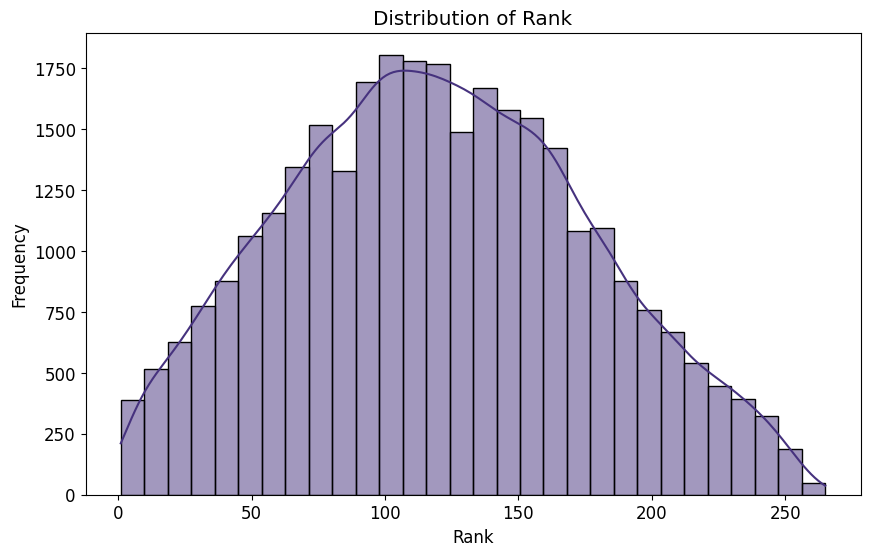

In [7]:
# Load the data
df = load_and_explore_data('Rank.csv')


  ## 3. Analyze Driver Patterns

In [8]:
def analyze_driver_patterns(df):
    """
    Analyze patterns in driver data and their relationship with rank
    
    Args:
        df: DataFrame with the data
        
    Returns:
        DataFrame with driver importance statistics
    """
    print("\nAnalyzing driver patterns...")
    
    # Get all driver columns
    driver_cols = [f'Driver{i}' for i in range(1, 18)]
    
    # Check unique factors in each driver column
    driver_factors = {}
    for col in driver_cols:
        unique_factors = df[col].unique()
        driver_factors[col] = unique_factors
        print(f"{col}: {len(unique_factors)} unique factors - {', '.join(unique_factors[:5])}...")
    
    # Initialize a DataFrame to store factor statistics
    factor_stats = []
    
    # For each driver and factor combination, calculate statistics
    for driver_col in driver_cols:
        for factor in df[driver_col].unique():
            # Get all rows where this driver has this factor
            factor_rows = df[df[driver_col] == factor]
            
            # Calculate average rank
            avg_rank = factor_rows['Rank'].mean()
            median_rank = factor_rows['Rank'].median()
            
            # Calculate how often this factor appears for this driver
            factor_count = len(factor_rows)
            factor_pct = factor_count / len(df) * 100
            
            # Add to statistics
            factor_stats.append({
                'Driver': driver_col,
                'Factor': factor,
                'Count': factor_count,
                'Percentage': factor_pct,
                'AvgRank': avg_rank,
                'MedianRank': median_rank
            })
    
    # Create a DataFrame
    factor_stats_df = pd.DataFrame(factor_stats)
    
    # Calculate driver importance based on rank variation
    driver_importance = factor_stats_df.groupby('Driver')['AvgRank'].agg(['std', 'count']).reset_index()
    driver_importance.columns = ['Driver', 'RankStdDev', 'FactorCount']
    
    # Higher std dev means the driver has a stronger impact on rank variation
    driver_importance = driver_importance.sort_values('RankStdDev', ascending=False)
    
    print("\nDriver importance based on rank variation:")
    print(driver_importance)
    
    # Visualize driver importance
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Driver', y='RankStdDev', data=driver_importance)
    plt.title('Driver Importance Based on Rank Variation')
    plt.xlabel('Driver')
    plt.ylabel('Standard Deviation of Rank')
    plt.xticks(rotation=45)
    plt.show()
    
    return factor_stats_df, driver_importance



Analyzing driver patterns...
Driver1: 17 unique factors - Factor6, Factor7, Factor11, Factor17, Factor16...
Driver2: 17 unique factors - Factor14, Factor7, Factor6, Factor11, Factor16...
Driver3: 17 unique factors - Factor7, Factor16, Factor1, Factor13, Factor6...
Driver4: 17 unique factors - Factor16, Factor14, Factor7, Factor12, Factor1...
Driver5: 17 unique factors - Factor1, Factor13, Factor14, Factor12, Factor10...
Driver6: 17 unique factors - Factor13, Factor12, Factor17, Factor16, Factor1...
Driver7: 17 unique factors - Factor11, Factor17, Factor12, Factor15, Factor14...
Driver8: 17 unique factors - Factor10, Factor13, Factor17, Factor16, Factor11...
Driver9: 17 unique factors - Factor15, Factor11, Factor13, Factor17, Factor16...
Driver10: 17 unique factors - Factor12, Factor9, Factor13, Factor10, Factor15...
Driver11: 17 unique factors - Factor17, Factor15, Factor12, Factor9, Factor14...
Driver12: 17 unique factors - Factor9, Factor8, Factor10, Factor11, Factor1...
Driver13: 1

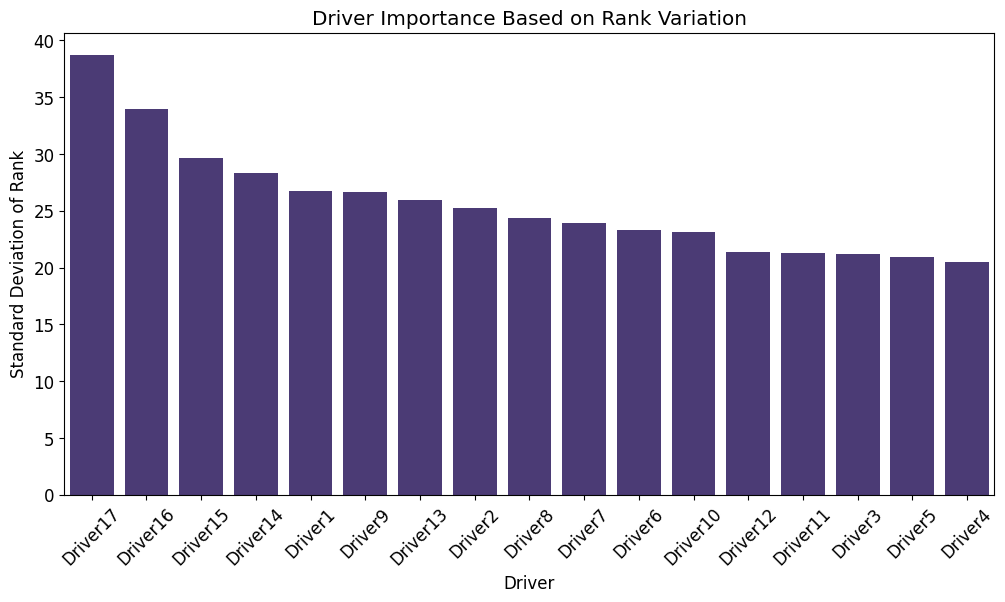

In [9]:
# Analyze driver patterns
factor_stats_df, driver_importance = analyze_driver_patterns(df)


  ## 4. Enhanced Feature Engineering



  We'll create features that capture the temporal nature of the data, the positional relationships between drivers

  and factors, and add our new historical features:

  1. Average Previous Ranks - Average of all previous ranks for a subject

  2. Average Change between Previous Ranks - Average of all previous rank changes

In [10]:
def engineer_enhanced_positional_features(df):
    """
    Perform feature engineering with positional encoding and historical features
    
    Args:
        df: Input DataFrame
        
    Returns:
        Processed DataFrame with positional and historical features
    """
    print("\nEngineering enhanced positional features...")

    # Sort by SubjectID and UpdateDT to ensure proper time ordering
    processed_df = df.sort_values(['SubjectID', 'UpdateDT']).copy()

    # Add time-based features
    processed_df['Year'] = processed_df['UpdateDT'].dt.year
    processed_df['Month'] = processed_df['UpdateDT'].dt.month
    processed_df['DayOfMonth'] = processed_df['UpdateDT'].dt.day
    processed_df['DayOfWeek'] = processed_df['UpdateDT'].dt.dayofweek

    # Days since first observation
    min_date = processed_df['UpdateDT'].min()
    processed_df['DaysSinceFirst'] = (processed_df['UpdateDT'] - min_date).dt.days

    # Days since previous observation for each subject
    processed_df['DaysSincePrev'] = processed_df.groupby('SubjectID')['UpdateDT'].diff().dt.days
    processed_df['DaysSincePrev'] = processed_df['DaysSincePrev'].fillna(0)

    # Add historical ranking features
    processed_df['PrevRank'] = processed_df.groupby('SubjectID')['Rank'].shift(1)
    processed_df['RankChange'] = processed_df['Rank'] - processed_df['PrevRank']

    # Set first rank change as NaN so it's ignored in the expanding mean
    processed_df.loc[processed_df.groupby('SubjectID').cumcount() == 0, 'RankChange'] = np.nan

    # Calculate average of all previous ranks (excluding current rank)
    processed_df['AvgPreviousRanks'] = processed_df.groupby('SubjectID')['Rank'].transform(
        lambda x: x.expanding().mean().shift(1)
    )

    # Fill missing values in AvgPreviousRanks with the first observed rank for the subject
    processed_df['AvgPreviousRanks'] = processed_df.groupby('SubjectID')['AvgPreviousRanks'].transform(
        lambda x: x.fillna(method='bfill').fillna(method='ffill')
    )

    # Fill missing values in AvgPreviousRankChanges with 0
    processed_df['AvgPreviousRankChanges'] = processed_df.groupby('SubjectID')['RankChange'].transform(
        lambda x: x.expanding().mean().shift(1)
    )
    processed_df['AvgPreviousRankChanges'] = processed_df['AvgPreviousRankChanges'].fillna(0)

    # Assign Factor values based on their Driver
    driver_cols = [f'Driver{i}' for i in range(1, 18)]

    # Melt DataFrame to long format
    melted_df = processed_df.melt(id_vars=['SubjectID', 'UpdateDT'], value_vars=driver_cols, 
                                  var_name='DriverCol', value_name='Factor')

    # Extract numerical driver ID (Driver1 → 1, Driver2 → 2, etc.)
    melted_df['Driver_Number'] = melted_df['DriverCol'].str.extract('(\d+)').astype(int)

    # Pivot back to wide format (Factor values now match Driver numbers)
    position_features = melted_df.pivot(index=['SubjectID', 'UpdateDT'], 
                                        columns='Factor', values='Driver_Number').fillna(0)

    # Merge back to the original DataFrame
    processed_df = processed_df.merge(position_features, on=['SubjectID', 'UpdateDT'], how='left')

    # Drop original driver columns (since we only want factors)
    processed_df.drop(columns=driver_cols, inplace=True)

    # Final NaN Handling (ensure model compatibility)
    processed_df.fillna(0, inplace=True)

    return processed_df


In [11]:
# Create enhanced positional features
df_enhanced = engineer_enhanced_positional_features(df)

# Display the first few rows to see the new features
print("\nSample data with enhanced features:")
display_cols = ['SubjectID', 'UpdateDT', 'Rank', 'PrevRank', 'RankChange', 'AvgPreviousRanks', 'AvgPreviousRankChanges']
print(df_enhanced[display_cols].head())




Engineering enhanced positional features...

Sample data with enhanced features:
   SubjectID            UpdateDT  Rank  PrevRank  RankChange  \
0          1 2021-05-06 14:13:00   189       0.0         0.0   
1          1 2021-05-15 21:41:00   170     189.0       -19.0   
2          1 2021-05-24 10:53:00   203     170.0        33.0   
3          1 2021-06-02 13:51:00   176     203.0       -27.0   
4          1 2021-06-13 22:57:00   184     176.0         8.0   

   AvgPreviousRanks  AvgPreviousRankChanges  
0        189.000000                0.000000  
1        189.000000                0.000000  
2        179.500000              -19.000000  
3        187.333333                7.000000  
4        184.500000               -4.333333  


In [12]:
# def prepare_data_for_prediction(file_path, scaler=None):
#     """
#     Load, preprocess, engineer features, and prepare data for prediction.

#     Args:
#         file_path (str): Path to the input CSV file.
#         scaler (StandardScaler, optional): Pre-trained scaler for feature standardization.

#     Returns:
#         processed_df (pd.DataFrame): Dataframe with enhanced features.
#         feature_cols (list): List of feature columns for modeling.
#         scaler (StandardScaler): Scaler object used for feature transformation.
#     """
#     print("Loading and processing data...")

#     # Load data
#     df = pd.read_csv(file_path)

#     # Convert date column to datetime
#     df['UpdateDT'] = pd.to_datetime(df['UpdateDT'])

#     # Remove duplicates
#     df = df.drop_duplicates()

#     # Sort by SubjectID and UpdateDT to ensure chronological order
#     df = df.sort_values(['SubjectID', 'UpdateDT']).copy()

#     # Add time-based features
#     df['Year'] = df['UpdateDT'].dt.year
#     df['Month'] = df['UpdateDT'].dt.month
#     df['DayOfMonth'] = df['UpdateDT'].dt.day
#     df['DayOfWeek'] = df['UpdateDT'].dt.dayofweek
#     df['DaysSinceFirst'] = (df['UpdateDT'] - df['UpdateDT'].min()).dt.days
#     df['DaysSincePrev'] = df.groupby('SubjectID')['UpdateDT'].diff().dt.days.fillna(0)

#     # Add historical ranking features
#     df['PrevRank'] = df.groupby('SubjectID')['Rank'].shift(1)
#     df['RankChange'] = df['Rank'] - df['PrevRank']
#     df.loc[df.groupby('SubjectID').cumcount() == 0, 'RankChange'] = np.nan

#     # Compute averages of previous ranks and rank changes
#     df['AvgPreviousRanks'] = df.groupby('SubjectID')['Rank'].transform(lambda x: x.expanding().mean().shift(1))
#     df['AvgPreviousRanks'] = df.groupby('SubjectID')['AvgPreviousRanks'].transform(lambda x: x.fillna(method='bfill').fillna(method='ffill'))
#     df['AvgPreviousRankChanges'] = df.groupby('SubjectID')['RankChange'].transform(lambda x: x.expanding().mean().shift(1)).fillna(0)

#     # Assign Factor values based on their Driver
#     driver_cols = [f'Driver{i}' for i in range(1, 18)]

#     # Convert wide format into long format
#     melted_df = df.melt(id_vars=['SubjectID', 'UpdateDT'], value_vars=driver_cols, var_name='DriverCol', value_name='Factor')

#     # Extract numerical driver ID (Driver1 → 1, Driver2 → 2, etc.)
#     melted_df['Driver_Number'] = melted_df['DriverCol'].str.extract('(\d+)').astype(int)

#     # Pivot back to wide format (Factor values now match Driver numbers)
#     position_features = melted_df.pivot(index=['SubjectID', 'UpdateDT'], columns='Factor', values='Driver_Number').fillna(0)

#     # Merge back to the original DataFrame
#     df = df.merge(position_features, on=['SubjectID', 'UpdateDT'], how='left')

#     # Drop original driver columns
#     df.drop(columns=driver_cols, inplace=True)

#     # Ensure model compatibility by filling NaNs
#     df.fillna(0, inplace=True)

#     # Define feature columns (Exclude non-feature columns)
#     exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'RankChange', 'Year', 'Month', 'DayOfMonth', 'DayOfWeek']
#     feature_cols = [col for col in df.columns if col not in exclude_cols]

#     print(f"Selected {len(feature_cols)} features for modeling.")

#     # Scale numerical features
#     if scaler is None:
#         scaler = StandardScaler()

#     # Identify numerical columns
#     numeric_cols = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()

#     # Apply scaling
#     if numeric_cols:
#         df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#     print(f"Data preparation complete. Shape: {df.shape}")

#     return df, feature_cols, scaler

# prepare_data_for_prediction(file_path='Rank.csv')


  ## 5. Train-Test Split



  We'll use a time-based split to simulate real forecasting conditions.

In [13]:
def prepare_train_test_data(df, test_size=0.2, scaler=None):
    """
    Prepare data for modeling using a time-based split
    
    Args:
        df: Input DataFrame
        test_size: Proportion of data to use for testing
        scaler: Scaler for standardizing features (if None, a new one will be created)
        
    Returns:
        X_train, X_test, y_train, y_test, feature_cols, scaler
    """
    print("\nPreparing data for modeling...")
    
    # Exclude non-feature columns
    exclude_cols = ['SubjectID', 'Rank', 'UpdateDT', 'RankChange', 'Year', 'Month', 'DayOfMonth', 'DayOfWeek', 'Quarter']
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    print(f"Selected {len(feature_cols)} features for modeling")
    
    # Sort by date
    df_sorted = df.sort_values('UpdateDT')
    
    # Find split point
    split_idx = int(len(df_sorted) * (1 - test_size))
    # Define cutoff date (e.g., last 6 months of data for testing)
    test_cutoff_date = df_sorted['UpdateDT'].max() - pd.DateOffset(months=6)

    # Split based on date
    train_df = df_sorted[df_sorted['UpdateDT'] < test_cutoff_date]
    test_df = df_sorted[df_sorted['UpdateDT'] >= test_cutoff_date]

    # Extract features and target
    X_train = train_df[feature_cols]
    y_train = train_df['Rank']
    X_test = test_df[feature_cols]
    y_test = test_df['Rank']
    
    # Fill any remaining NaN values in features
    X_train.fillna(0, inplace=True)
    X_test.fillna(0, inplace=True)

    # Scale numerical features
    if scaler is None:
        scaler = StandardScaler()
        
    # Find numerical columns
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    # Scale only numeric columns
    if numeric_cols:
        X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
        X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    print(f"Final shapes - X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, feature_cols, scaler



In [14]:
# Prepare data for modeling
X_train, X_test, y_train, y_test, feature_cols, scaler = prepare_train_test_data(df_enhanced)



Preparing data for modeling...
Selected 22 features for modeling
Final shapes - X_train: (23129, 22), X_test: (7638, 22)


In [15]:
X_train.head()

,DaysSinceFirst,DaysSincePrev,PrevRank,AvgPreviousRanks,AvgPreviousRankChanges,Factor1,Factor10,Factor11,Factor12,Factor13,...,Factor16,Factor17,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9
0,-1.257211,-1.700161,-1.836588,1.337448,0.004367,5,8,7,10,6,...,4,11,17,13,16,14,1,3,15,12
10399,-1.257211,-1.700161,-1.836588,-0.507665,0.004367,4,12,7,8,9,...,6,10,15,16,17,2,1,3,14,13
10426,-1.257211,-1.700161,-1.836588,1.280383,0.004367,6,9,1,3,7,...,13,10,5,17,16,15,2,4,14,12
1684,-1.257211,-1.700161,-1.836588,-0.621795,0.004367,5,8,1,10,11,...,6,7,14,17,16,15,2,3,13,12
23069,-1.257211,-1.700161,-1.836588,0.823860,0.004367,6,9,2,5,8,...,4,10,15,17,16,14,1,13,12,11


In [16]:
X_test.head()

,DaysSinceFirst,DaysSincePrev,PrevRank,AvgPreviousRanks,AvgPreviousRankChanges,Factor1,Factor10,Factor11,Factor12,Factor13,...,Factor16,Factor17,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9
9172,2.407707,1.379143,0.066964,-0.351686,0.304445,1,10,3,5,4,...,13,14,7,17,15,16,6,9,12,8
4623,2.407707,1.379143,-0.535014,-0.319349,-0.013638,17,8,3,7,2,...,4,6,14,16,11,13,10,15,12,9
9440,2.407707,1.379143,1.937977,1.514350,0.730556,1,7,3,2,9,...,4,8,12,17,14,16,15,13,11,10
15030,2.407707,1.379143,0.668942,0.714485,-0.175680,1,11,2,10,9,...,3,4,14,15,17,16,6,7,12,13
29679,2.407707,1.379143,2.328449,1.972775,0.376464,5,9,7,11,8,...,2,6,16,17,14,15,1,4,12,13


In [17]:
y_train.head()

0        189
10399     92
10426    186
1684      86
23069    162
Name: Rank, dtype: int64

  ## 6. Hyperparameter Tuning for Models

In [18]:
def tune_random_forest(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Random Forest hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Random Forest hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': [None] + list(range(5, 51, 10)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2', None]
    }
    
    # Create base model
    rf_base = RandomForestRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    rf_search = RandomizedSearchCV(
        rf_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    rf_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {rf_search.best_params_}")
    print(f"Best MAE: {-rf_search.best_score_:.2f}")
    
    return rf_search.best_estimator_

def tune_gradient_boosting(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune Gradient Boosting hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning Gradient Boosting hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'max_features': uniform(0.5, 0.5)
    }
    
    # Create base model
    gb_base = GradientBoostingRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    gb_search = RandomizedSearchCV(
        gb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    gb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {gb_search.best_params_}")
    print(f"Best MAE: {-gb_search.best_score_:.2f}")
    
    return gb_search.best_estimator_

def tune_lightgbm(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune LightGBM hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning LightGBM hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'num_leaves': randint(20, 100),
        'min_child_samples': randint(10, 50),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5)
    }
    
    # Create base model
    lgbm_base = lgbm.LGBMRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    lgbm_search = RandomizedSearchCV(
        lgbm_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    lgbm_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {lgbm_search.best_params_}")
    print(f"Best MAE: {-lgbm_search.best_score_:.2f}")
    
    return lgbm_search.best_estimator_

def tune_xgboost(X_train, y_train, tscv, n_iter=20, verbose=1):
    """
    Tune XGBoost hyperparameters
    
    Args:
        X_train: Training features
        y_train: Training target
        tscv: Time series cross-validation object
        n_iter: Number of parameter combinations to try
        verbose: Verbosity level
        
    Returns:
        Tuned model
    """
    print("\nTuning XGBoost hyperparameters...")
    
    # Define parameter distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 10),
        'subsample': uniform(0.5, 0.5),
        'colsample_bytree': uniform(0.5, 0.5),
        'gamma': uniform(0, 1)
    }
    
    # Create base model
    xgb_base = xgb.XGBRegressor(random_state=42)
    
    # Create RandomizedSearchCV
    xgb_search = RandomizedSearchCV(
        xgb_base,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=verbose,
        random_state=42
    )
    
    # Fit RandomizedSearchCV
    start_time = time.time()
    xgb_search.fit(X_train, y_train)
    tuning_time = time.time() - start_time
    
    # Print results
    print(f"Tuning completed in {tuning_time:.2f} seconds")
    print(f"Best parameters: {xgb_search.best_params_}")
    print(f"Best MAE: {-xgb_search.best_score_:.2f}")
    
    return xgb_search.best_estimator_


In [19]:
# Create a TimeSeriesSplit for parameter tuning
tscv = TimeSeriesSplit(n_splits=5)

# Flag to control whether to run tuning (can be time consuming)
run_tuning = True  # Set to True to run tuning

# Tune models with enhanced positional features
if run_tuning:
    rf_tuned = tune_random_forest(X_train, y_train, tscv, n_iter=20)
    gb_tuned = tune_gradient_boosting(X_train, y_train, tscv, n_iter=20)
    lgbm_tuned = tune_lightgbm(X_train, y_train, tscv, n_iter=20)
    xgb_tuned = tune_xgboost(X_train, y_train, tscv, n_iter=20)
else:
    # If not tuning, use default parameters
    rf_tuned = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    gb_tuned = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    lgbm_tuned = lgbm.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_tuned = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, n_jobs=-1)



Tuning Random Forest hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 217.47 seconds
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 12, 'n_estimators': 292}
Best MAE: 18.93

Tuning Gradient Boosting hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Tuning completed in 248.52 seconds
Best parameters: {'learning_rate': 0.021616722433639893, 'max_depth': 7, 'max_features': 0.8005575058716043, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 199, 'subsample': 0.5282057895135501}
Best MAE: 18.89

Tuning LightGBM hyperparameters...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set

  ## 7. Model Training and Evaluation Functions

In [20]:
def evaluate_model(y_true, y_pred, name):
    """
    Evaluate model using multiple metrics suitable for ordinal prediction
    
    Args:
        y_true: True values
        y_pred: Predicted values
        name: Model name
        
    Returns:
        Dictionary of evaluation metrics
    """
    # Standard regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Rank correlation coefficients
    spearman, _ = spearmanr(y_true, y_pred)
    kendall, _ = kendalltau(y_true, y_pred)
    
    # Custom accuracy metrics - within N ranks
    accuracy_5 = np.mean(np.abs(y_true - y_pred) <= 5)
    accuracy_10 = np.mean(np.abs(y_true - y_pred) <= 10)
    accuracy_20 = np.mean(np.abs(y_true - y_pred) <= 20)
    
    # Print results
    print(f"\n--- {name} Evaluation Results ---")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.4f}")
    print(f"Spearman Correlation: {spearman:.4f}")
    print(f"Kendall's Tau: {kendall:.4f}")
    print(f"Accuracy within 5 ranks: {accuracy_5:.2%}")
    print(f"Accuracy within 10 ranks: {accuracy_10:.2%}")
    print(f"Accuracy within 20 ranks: {accuracy_20:.2%}")
    
    # Return as dictionary
    return {
        'name': name,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'spearman': spearman,
        'kendall': kendall,
        'accuracy_5': accuracy_5,
        'accuracy_10': accuracy_10,
        'accuracy_20': accuracy_20
    }

def plot_predictions(y_true, y_pred, name):
    """
    Plot actual vs predicted values and error distribution
    
    Args:
        y_true: True values
        y_pred: Predicted values
        name: Model name
    """
    # Plot actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_true.min(), min(y_pred))
    max_val = max(y_true.max(), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(sorted(y_true), p(sorted(y_true)), 'g-', linewidth=2)
    
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(f'{name} - Actual vs Predicted')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot error distribution
    errors = y_pred - y_true
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, kde=True, bins=30)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'{name} - Error Distribution')
    plt.grid(True, alpha=0.3)
    plt.show()

def train_model(X_train, y_train, X_test, y_test, model, model_name):
    """
    Train and evaluate a model
    
    Args:
        X_train: Training features
        y_train: Training targets
        X_test: Test features
        y_test: Test targets
        model: Model to train
        model_name: Name of the model for reporting
        
    Returns:
        Dictionary with evaluation metrics and trained model
    """
    print(f"\nTraining {model_name}...")
    
    # Time the training
    start_time = time.time()
    
    # Fit the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate training time
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Evaluate model
    metrics = evaluate_model(y_test, y_pred, model_name)
    metrics['model'] = model
    metrics['train_time'] = train_time
    
    # Plot predictions
    plot_predictions(y_test, y_pred, model_name)
    
    return metrics


In [21]:
# X_test.iloc[0]

In [22]:
# A = X_test.head(1)

# A1 = A.copy()
# A1["Factor1"] = 5
# A1["Factor12"] = 1

# A
# A1

# print(rf_tuned.predict(A))
# print(rf_tuned.predict(A1))


  ## 9. Model Comparison

In [28]:
def compare_models(model_results):
    """
    Compare model performance across multiple metrics
    
    Args:
        model_results: Dictionary with model metrics
    """
    # Create a DataFrame with all results
    models = []
    
    for model_name, metrics in model_results.items():
        model_data = {
            'Model': model_name,
            'MAE': metrics['mae'],
            'RMSE': metrics['rmse'],
            'R²': metrics['r2'],
            'Spearman': metrics['spearman'],
            'Kendall': metrics['kendall'],
            'Accuracy ≤5': metrics['accuracy_5'],
            'Accuracy ≤10': metrics['accuracy_10'],
            'Accuracy ≤20': metrics['accuracy_20'],
            'Training Time (s)': metrics['train_time']
        }
        models.append(model_data)
    
    # Create DataFrame and sort by MAE
    comparison_df = pd.DataFrame(models).sort_values('MAE')
    
    print("\n--- Model Comparison ---")
    print(comparison_df)
    
    # Create comparison visualizations
    metrics_to_plot = ['MAE', 'RMSE', 'R²', 'Spearman', 'Accuracy ≤10']
    
    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Sort by metric
        if metric in ['MAE', 'RMSE']:
            # Lower is better
            sorted_df = comparison_df.sort_values(metric)
        else:
            # Higher is better
            sorted_df = comparison_df.sort_values(metric, ascending=False)
        
        # Create bar chart
        sns.barplot(x='Model', y=metric, data=sorted_df)
        plt.title(f'Model Comparison - {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # Return the best model based on MAE
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\nBest model based on MAE: {best_model_name}")
    print(f"MAE: {comparison_df.iloc[0]['MAE']:.2f}")
    
    return comparison_df

In [ ]:
# compare_models(model_results)

In [30]:
importances = {}

def plot_feature_importance(model, feature_names, model_name, top_n=15):
    """
    Plot feature importance for a trained model.

    Args:
        model: Trained model (supports tree-based models).
        feature_names: List of feature names.
        model_name: Name of the model.
        top_n: Number of top features to display.
    """
    print(f"\nPlotting feature importance for {model_name}...")

    # Retrieve feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    else:
        print(f"Feature importance not available for {model_name}. Skipping.")
        return
    
    # Store importance for later comparison
    importances[model_name] = importance
    
    # Create DataFrame
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature Name')
    plt.grid(True, alpha=0.3)
    plt.show()


def compare_models(model_results):
    """
    Compare model performance across multiple metrics.
    
    Args:
        model_results: Dictionary with model evaluation results.
        
    Returns:
        DataFrame with model comparison.
    """
    models = []
    
    for model_name, metrics in model_results.items():
        model_data = {
            'Model': model_name,
            'MAE': metrics['mae'],
            'RMSE': metrics['rmse'],
            'R²': metrics['r2'],
            'Spearman': metrics['spearman'],
            'Kendall': metrics['kendall'],
            'Accuracy ≤5': metrics['accuracy_5'],
            'Accuracy ≤10': metrics['accuracy_10'],
            'Accuracy ≤20': metrics['accuracy_20'],
            'Training Time (s)': metrics['train_time']
        }
        models.append(model_data)
    
    # Create DataFrame
    comparison_df = pd.DataFrame(models).sort_values('MAE')

    # Display
    print("\n--- Model Comparison ---")
    print(comparison_df)
    
    # Visualization
    metrics_to_plot = ['MAE', 'RMSE', 'R²', 'Spearman', 'Accuracy ≤10']

    for metric in metrics_to_plot:
        plt.figure(figsize=(12, 6))
        
        # Sort by metric
        if metric in ['MAE', 'RMSE']:
            sorted_df = comparison_df.sort_values(metric)
        else:
            sorted_df = comparison_df.sort_values(metric, ascending=False)
        
        # Bar chart
        sns.barplot(x='Model', y=metric, data=sorted_df, palette='magma')
        plt.title(f'Model Comparison - {metric}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3)
        plt.show()

    # Return best model based on MAE
    best_model_name = comparison_df.iloc[0]['Model']
    print(f"\nBest model based on MAE: {best_model_name}")
    print(f"MAE: {comparison_df.iloc[0]['MAE']:.2f}")
    
    return comparison_df


  ## 8. Train and Evaluate Enhanced Positional Models


Training Random Forest (Enhanced)...
Training completed in 62.46 seconds

--- Random Forest (Enhanced) Evaluation Results ---
MAE: 17.88
RMSE: 25.03
R²: 0.8059
Spearman Correlation: 0.8962
Kendall's Tau: 0.7374
Accuracy within 5 ranks: 21.43%
Accuracy within 10 ranks: 40.14%
Accuracy within 20 ranks: 67.64%


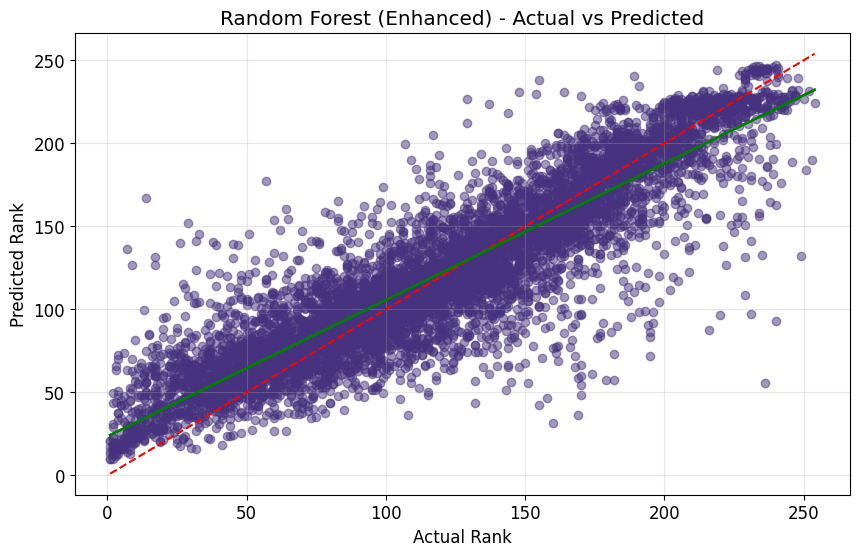

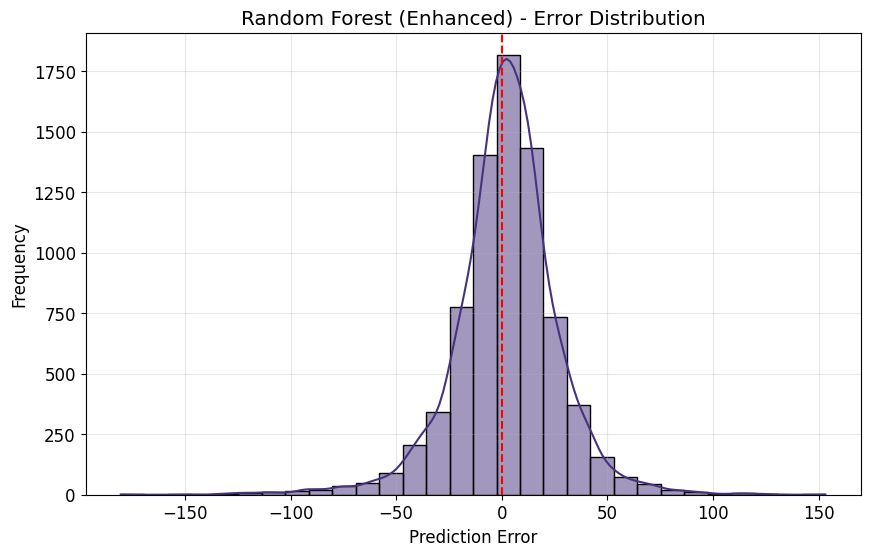


Plotting feature importance for Random Forest (Enhanced)...


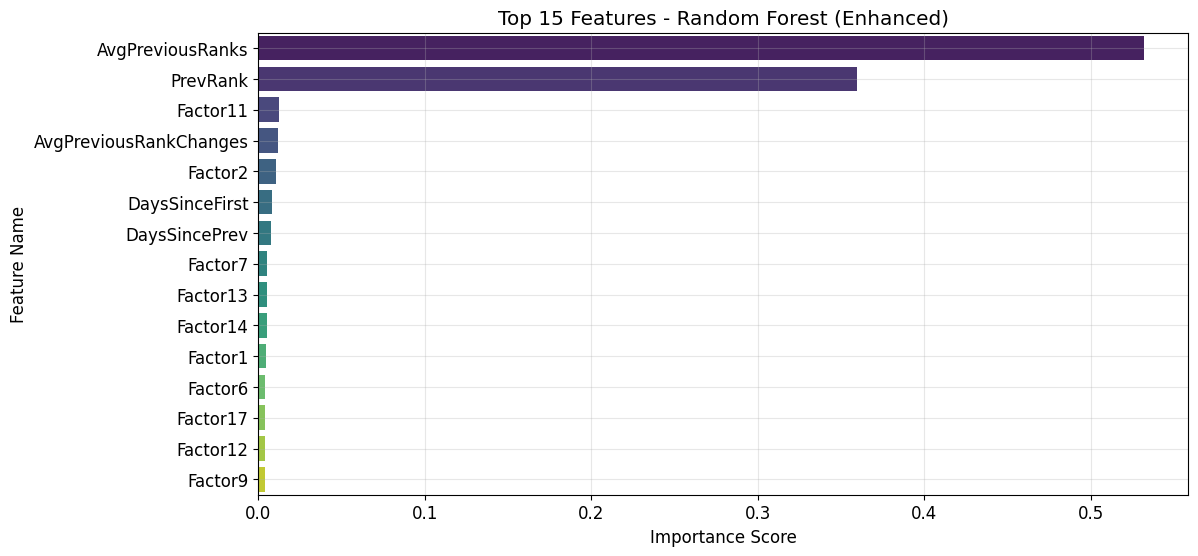


Training Gradient Boosting (Enhanced)...
Training completed in 14.59 seconds

--- Gradient Boosting (Enhanced) Evaluation Results ---
MAE: 17.96
RMSE: 25.06
R²: 0.8054
Spearman Correlation: 0.8967
Kendall's Tau: 0.7366
Accuracy within 5 ranks: 21.35%
Accuracy within 10 ranks: 40.27%
Accuracy within 20 ranks: 67.16%


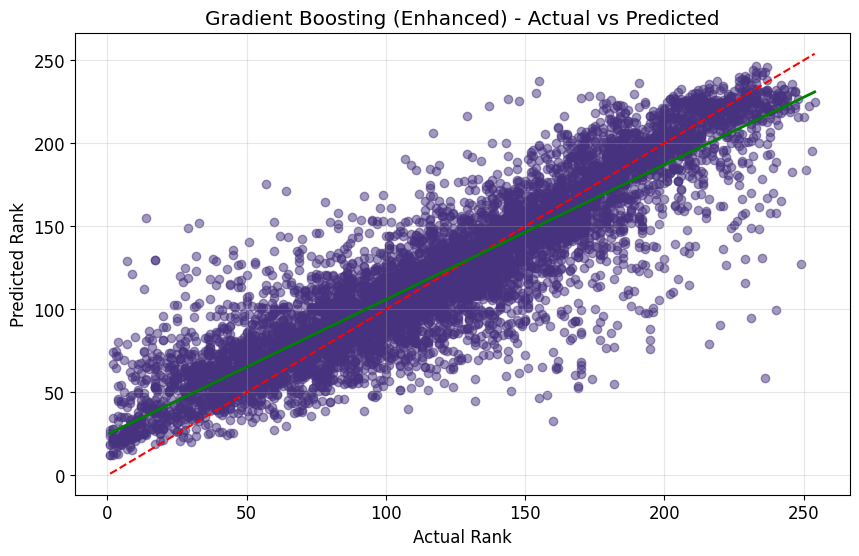

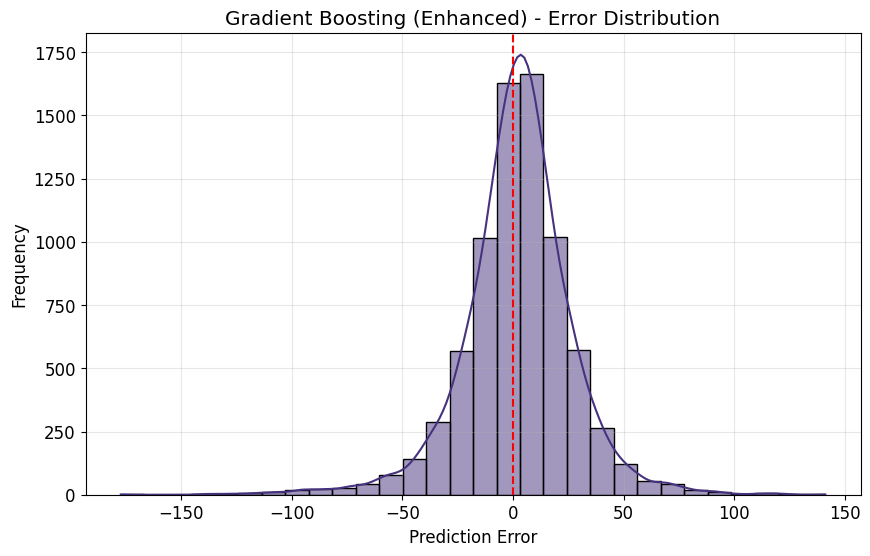


Plotting feature importance for Gradient Boosting (Enhanced)...


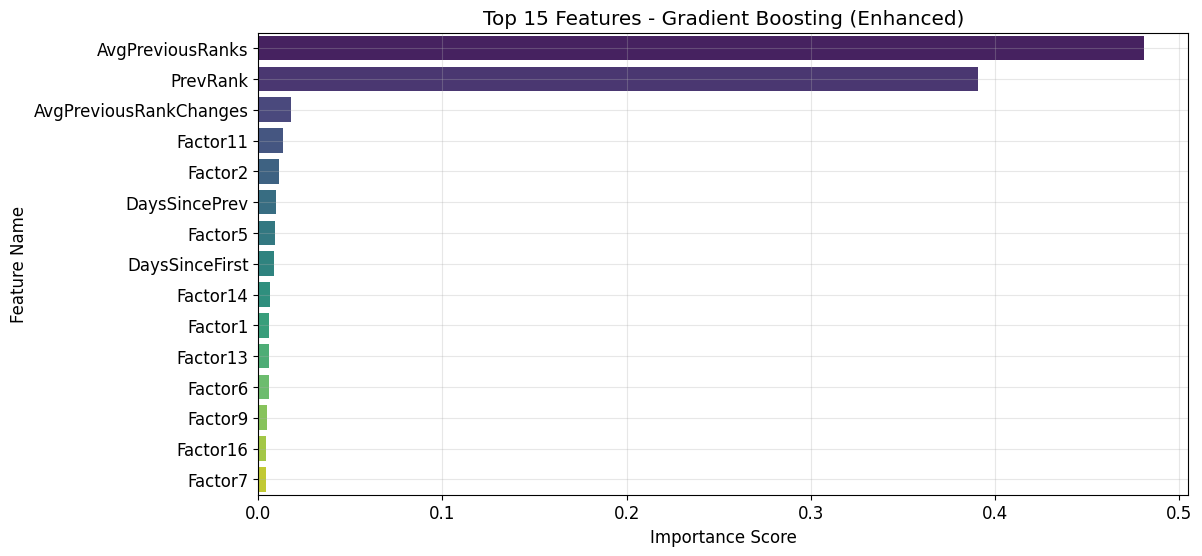


Training LightGBM (Enhanced)...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1104
[LightGBM] [Info] Number of data points in the train set: 23129, number of used features: 22
[LightGBM] [Info] Start training from score 119.513165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

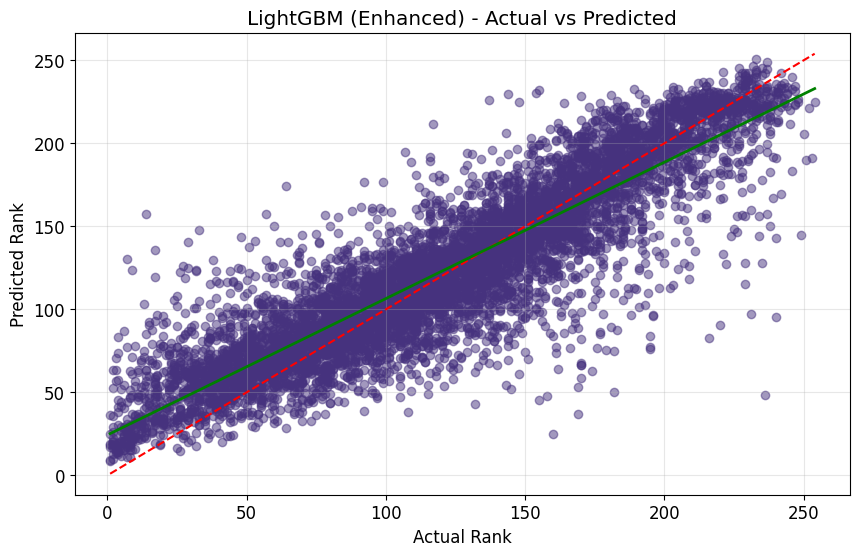

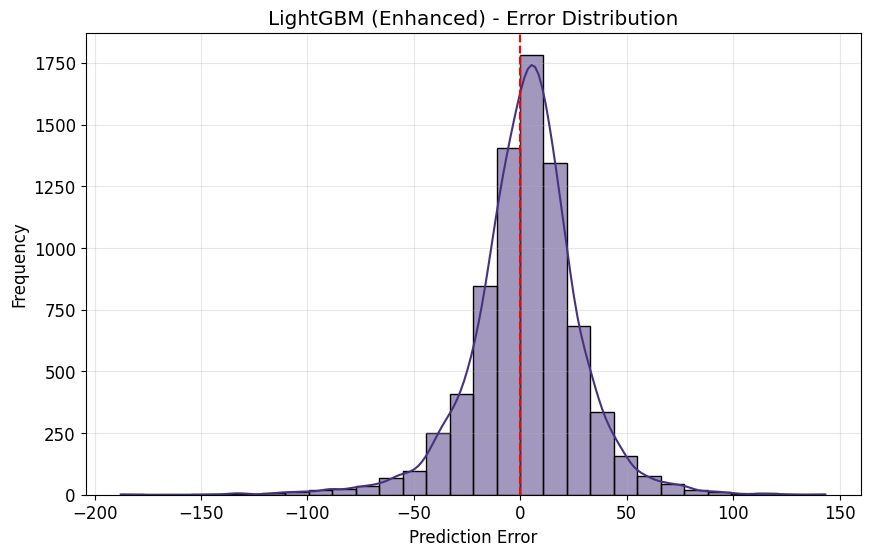


Plotting feature importance for LightGBM (Enhanced)...


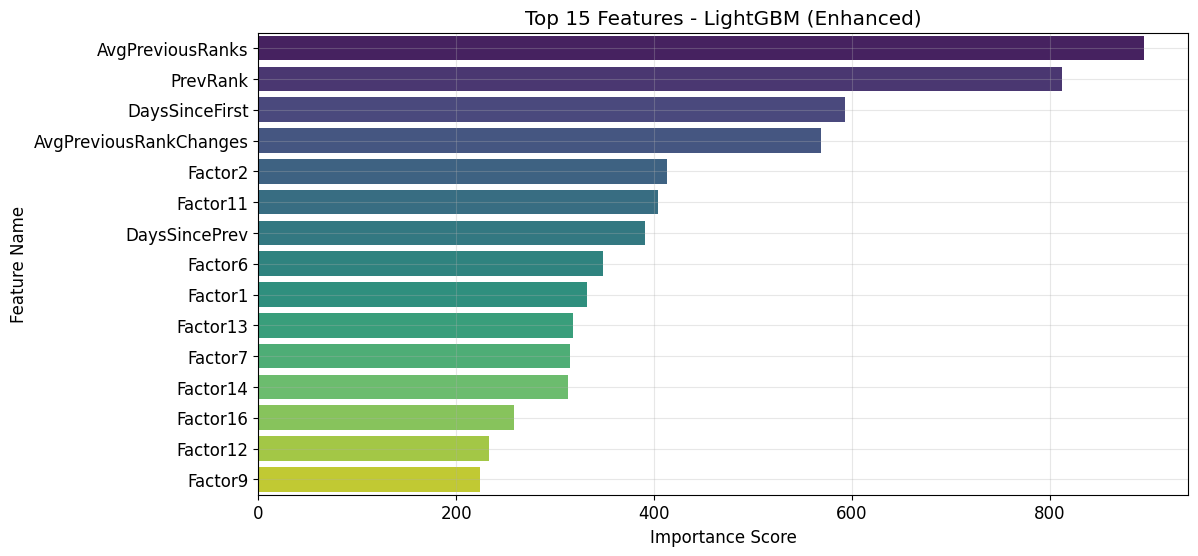


Training XGBoost (Enhanced)...
Training completed in 0.54 seconds

--- XGBoost (Enhanced) Evaluation Results ---
MAE: 18.88
RMSE: 25.81
R²: 0.7937
Spearman Correlation: 0.8928
Kendall's Tau: 0.7279
Accuracy within 5 ranks: 19.59%
Accuracy within 10 ranks: 36.82%
Accuracy within 20 ranks: 64.49%


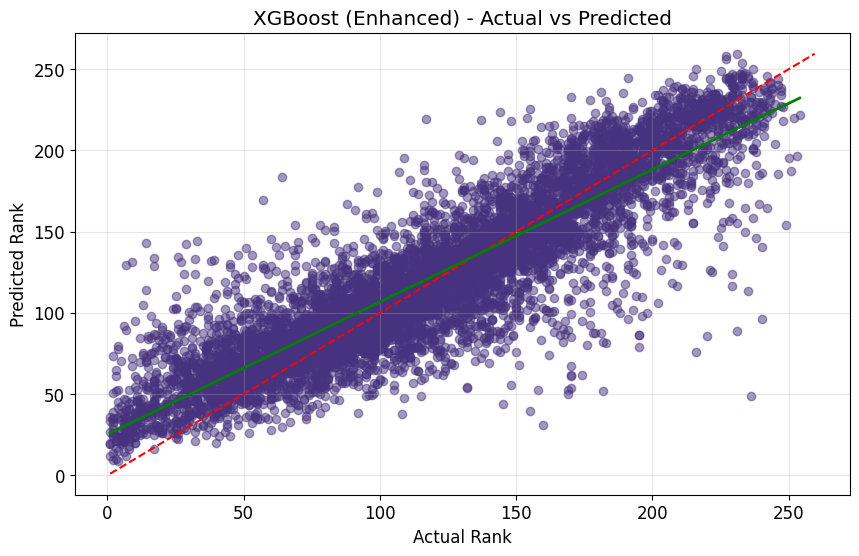

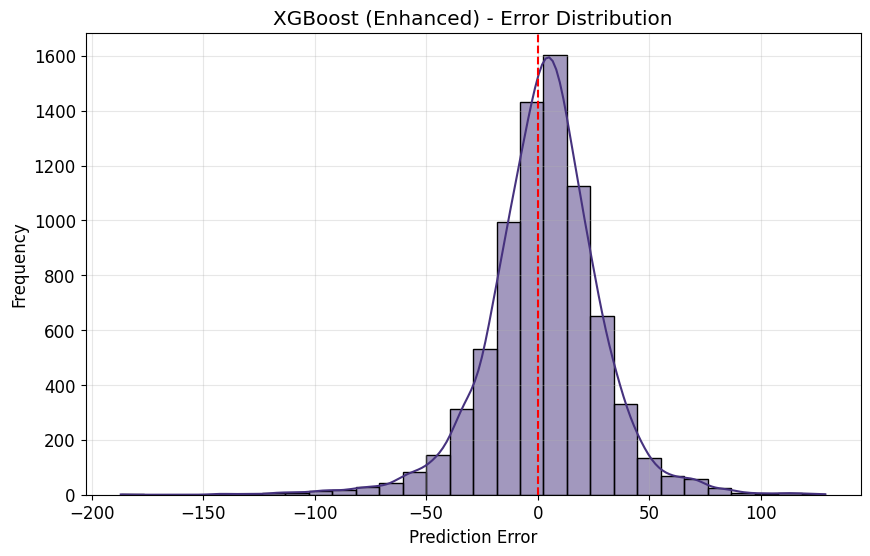


Plotting feature importance for XGBoost (Enhanced)...


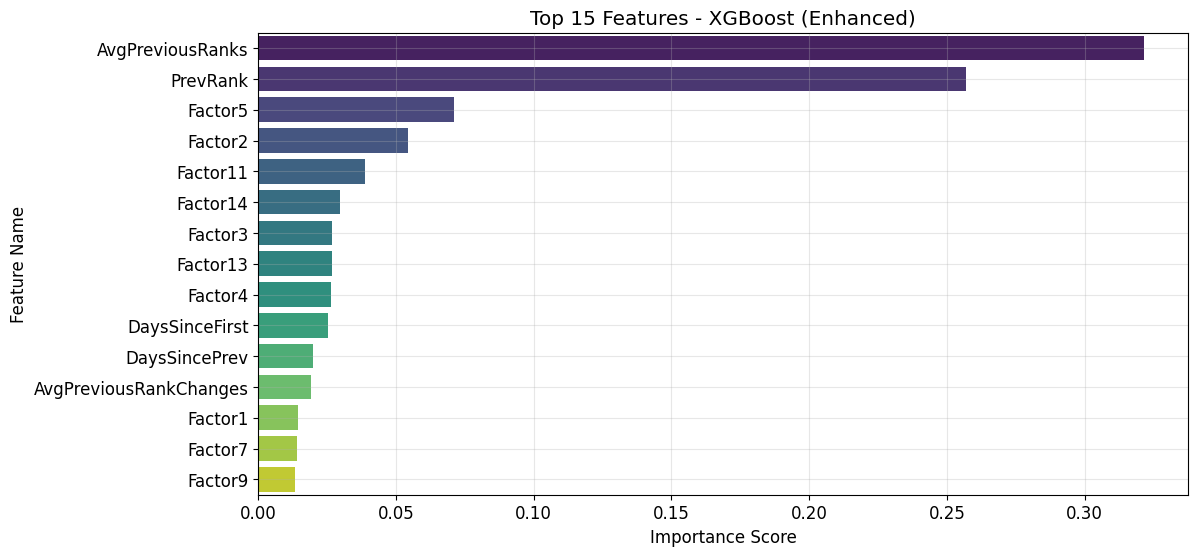


--- Model Comparison ---
                          Model        MAE       RMSE        R²  Spearman  \
0      Random Forest (Enhanced)  17.875493  25.033893  0.805866  0.896240   
1  Gradient Boosting (Enhanced)  17.959458  25.063494  0.805406  0.896684   
2           LightGBM (Enhanced)  18.454477  25.411860  0.799959  0.895221   
3            XGBoost (Enhanced)  18.882199  25.807565  0.793681  0.892804   

    Kendall  Accuracy ≤5  Accuracy ≤10  Accuracy ≤20  Training Time (s)  
0  0.737382     0.214323      0.401414      0.676355          62.460139  
1  0.736644     0.213538      0.402723      0.671642          14.587156  
2  0.732589     0.196648      0.381121      0.660775           0.886082  
3  0.727913     0.195863      0.368159      0.644933           0.535538  


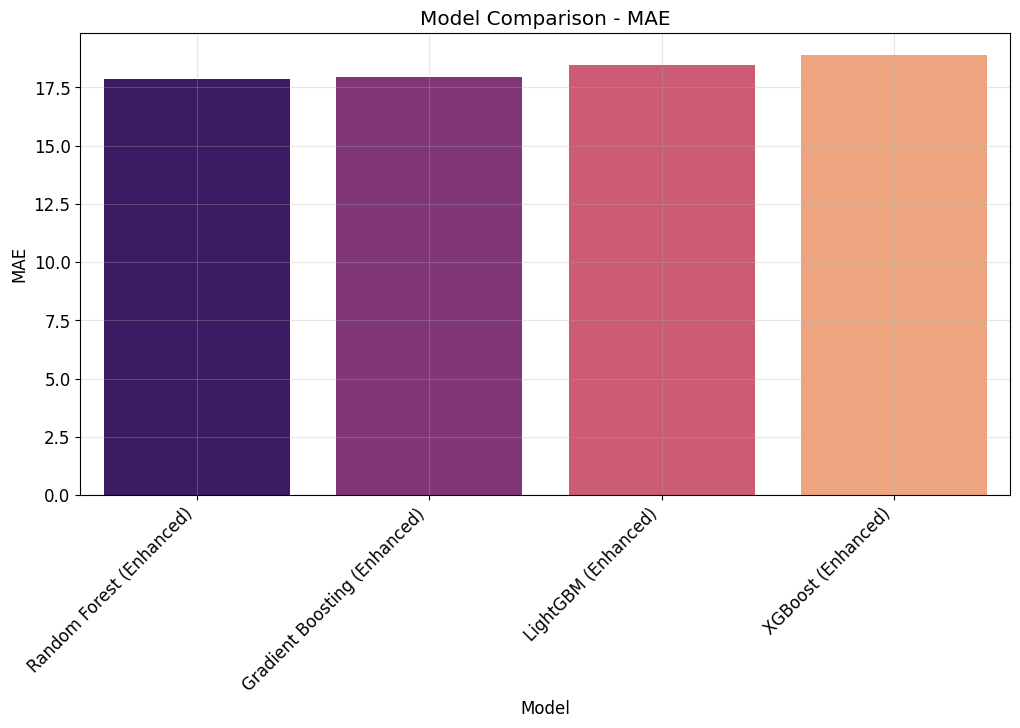

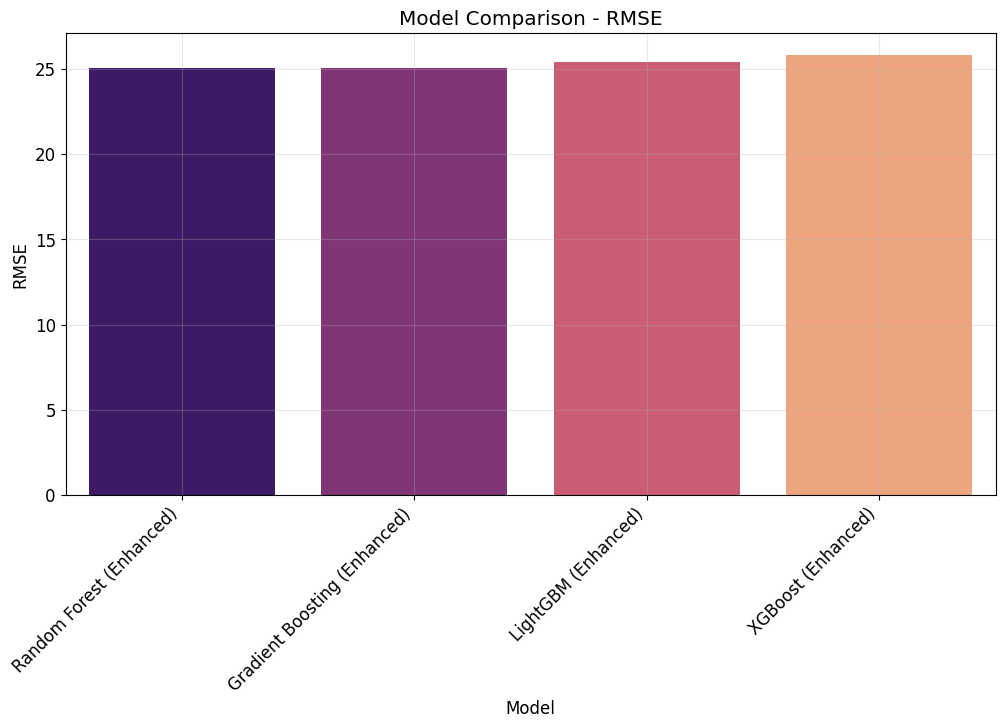

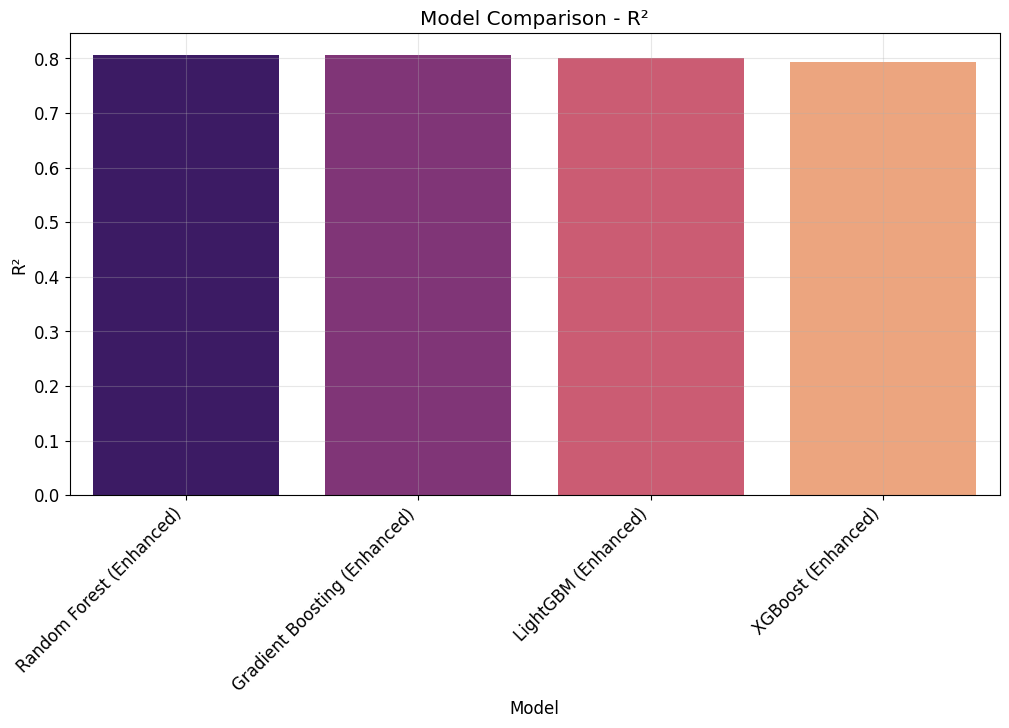

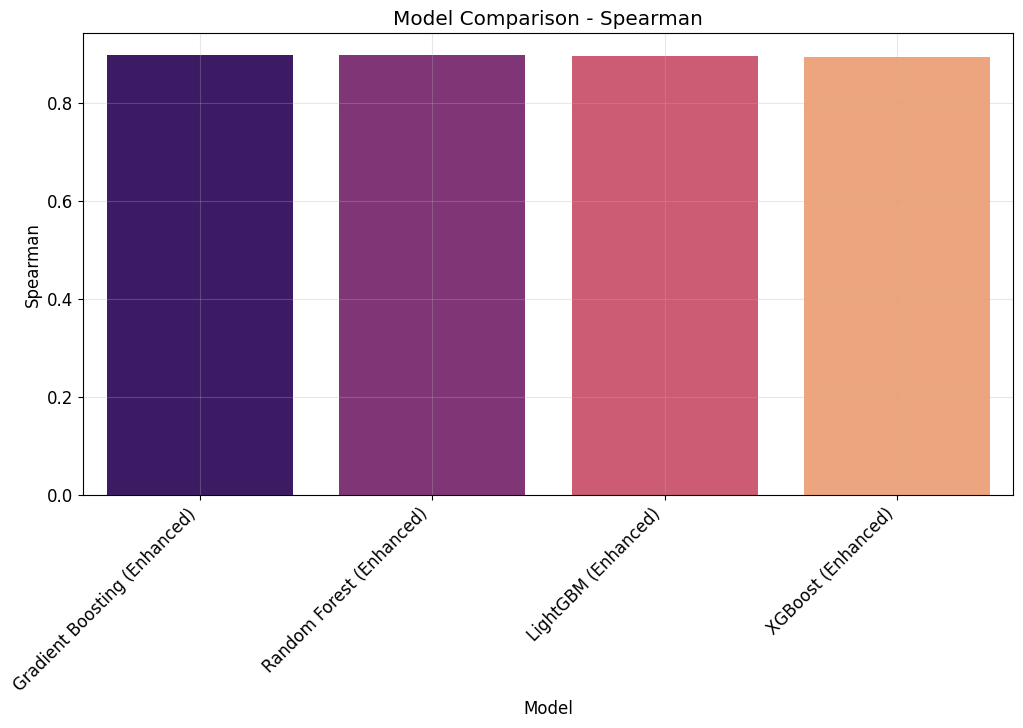

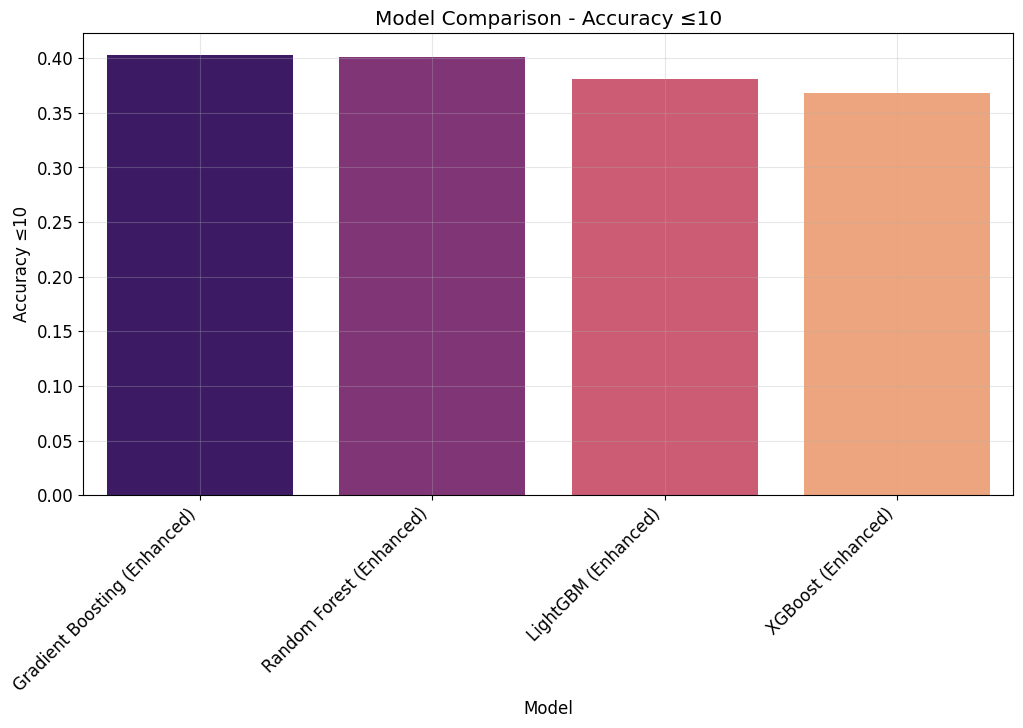


Best model based on MAE: Random Forest (Enhanced)
MAE: 17.88


In [31]:
# # Dictionary to store model results
# model_results = {}

# # Train all models with the enhanced positional features
# model_results["Random Forest (Enhanced)"] = train_model(X_train, y_train, X_test, y_test, rf_tuned, "Random Forest (Enhanced)")
# model_results["Gradient Boosting (Enhanced)"] = train_model(X_train, y_train, X_test, y_test, gb_tuned, "Gradient Boosting (Enhanced)")
# model_results["LightGBM (Enhanced)"] = train_model(X_train, y_train, X_test, y_test, lgbm_tuned, "LightGBM (Enhanced)")
# model_results["XGBoost (Enhanced)"] = train_model(X_train, y_train, X_test, y_test, xgb_tuned, "XGBoost (Enhanced)")

# Define your tuned (or default) models up front
models = {
    "Random Forest (Enhanced)": rf_tuned,
    "Gradient Boosting (Enhanced)": gb_tuned,
    "LightGBM (Enhanced)": lgbm_tuned,
    "XGBoost (Enhanced)": xgb_tuned
}

# Initialize a dictionary to hold the results
model_results = {}

# Loop once through each model
for name, model in models.items():
    # Train and evaluate the model
    model_results[name] = train_model(X_train, y_train, X_test, y_test, model, name)
    
    # Plot feature importance for tree-based models
    plot_feature_importance(model, feature_cols, name)


# Compare models
model_comparison_df = compare_models(model_results)

# Saving Files

In [33]:
# Assume model_comparison_df is the DataFrame returned by compare_models(model_results)
# and that it is sorted by MAE ascending.
best_model_name = model_comparison_df.iloc[0]['Model']

# We will build a list of rows for our final CSV
rows_for_csv = []

for m_name, data in model_results.items():
    # Create a filename for this model:
    filename = (
        m_name.lower()
        .replace(' ', '_')
        .replace('(', '')
        .replace(')', '')
        + ".pkl"
    )

    row = {
        'model_name': m_name,
        'filename': filename,
        'mae': data['mae'],
        'rmse': data['rmse'],
        'r2': data['r2'],
        'spearman': data['spearman'],
        'kendall': data['kendall'],
        'accuracy_5': data['accuracy_5'],
        'accuracy_10': data['accuracy_10'],
        'accuracy_20': data['accuracy_20'],
        # Compare m_name with the best_model_name to flag whether it's the best
        'is_best_model': (m_name == best_model_name)
    }
    rows_for_csv.append(row)

# Convert list of rows into a DataFrame
final_results_df = pd.DataFrame(rows_for_csv)

# Save to CSV
final_results_df.to_csv('model_results.csv', index=False)
print("model_results.csv has been saved with the desired columns.")


model_results.csv has been saved with the desired columns.


In [ ]:
import pickle

def save_model(model, filename, additional_data=None):
    """
    Save a trained model along with its metadata.

    Args:
        model: Trained model object.
        filename: Name of the file to save the model (without extension).
        additional_data: Dictionary containing extra information such as feature names, scalers, evaluation metrics, etc.
    """
    file_path = f"{filename}.pkl"
    
    with open(file_path, 'wb') as file:
        pickle.dump({'model': model, 'metadata': additional_data}, file)
    
    print(f"Model saved successfully: {file_path}")


for model_name, model_data in model_results.items():
    model = model_data['model']
    filename = model_name.lower().replace(' ', '_').replace('(', '').replace(')', '')

    save_model(
        model,
        filename,
        additional_data={
            'scaler': scaler,
            'feature_cols': feature_cols,
            'metrics': {k: v for k, v in model_data.items() if k != 'model'},
            'is_best_model': (model_name == model_comparison_df.iloc[0]['Model'])
        }
    )
